In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!find '/content/drive/My Drive/' -type d -name 'data_with_annotators_labels'

/content/drive/My Drive/data_with_annotators_labels


<ipython-input-3-1dc2e05b325e>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['final_label'] = data['final_label'].replace(label_mapping)


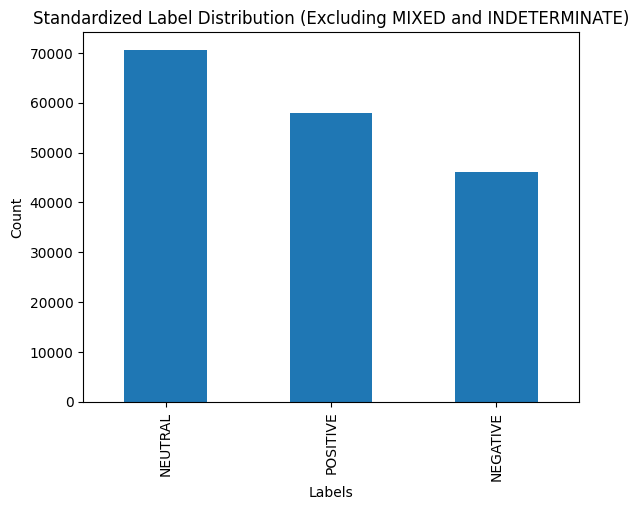

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Evaluation results: {'eval_loss': 0.8830885291099548, 'eval_runtime': 61.3245, 'eval_samples_per_second': 570.164, 'eval_steps_per_second': 142.553, 'epoch': 3.0}


In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
import matplotlib.pyplot as plt

# Step 1: Load Data in Chunks with Column Check
folder_path = '/content/drive/My Drive/data_with_annotators_labels'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Load in chunks to avoid memory overload
dataframes = []
required_columns = ['text', 'label_1', 'label_2', 'label_3']

for csv_file in csv_files:
    for chunk in pd.read_csv(os.path.join(folder_path, csv_file), chunksize=10000):
        # Only keep rows with the required columns
        if all(col in chunk.columns for col in required_columns):
            dataframes.append(chunk[required_columns])

# Concatenate the data if we have any valid dataframes
if dataframes:
    data = pd.concat(dataframes, ignore_index=True)
else:
    raise ValueError("None of the CSV files contain the required columns: 'text', 'label_1', 'label_2', 'label_3'")

# Step 2: Consolidate Labels Using Majority Voting
def consolidate_labels(row):
    labels = [row['label_1'], row['label_2'], row['label_3']]
    labels = [label for label in labels if pd.notna(label)]
    if labels:
        return max(set(labels), key=labels.count)
    return None

data['final_label'] = data.apply(consolidate_labels, axis=1)
data = data.dropna(subset=['text', 'final_label'])  # Drop rows with missing values

# Step 3: Label Standardization
label_mapping = {
    'neutral': 'NEUTRAL', 'positive': 'POSITIVE', 'negative': 'NEGATIVE',
    'indeterminate': 'INDETERMINATE', 'inderminate': 'INDETERMINATE',
    'Neutral': 'NEUTRAL', 'Positive': 'POSITIVE', 'Negative': 'NEGATIVE',
    'NEUTRAL': 'NEUTRAL', 'POSITIVE': 'POSITIVE', 'NEGATIVE': 'NEGATIVE',
    'MIXED': 'MIXED', 'mixed': 'MIXED', 'Indeterminate': 'INDETERMINATE'
}
data['final_label'] = data['final_label'].replace(label_mapping)

# Step 4: Filter Out "MIXED" and "INDETERMINATE" Labels
data = data[~data['final_label'].isin(['MIXED', 'INDETERMINATE'])]

# Step 5: Visualize Label Distribution
label_counts = data['final_label'].value_counts()
label_counts.plot(kind='bar')
plt.title('Standardized Label Distribution (Excluding MIXED and INDETERMINATE)')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

# Step 6: Prepare Data for Training
texts = data['text'].values
labels = data['final_label'].values

X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Step 7: Tokenization Using a Lightweight Model
# Use DistilBert tokenizer for a smaller model size
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

# Step 8: Label Encoding
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_)

# Step 9: Custom Dataset Class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, y_train)
test_dataset = CustomDataset(test_encodings, y_test)

# Step 10: Define and Load a Lightweight Model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_classes)

# Step 11: Training Arguments with Small Batch Size
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

# Step 12: Trainer Initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Step 13: Train the Model
trainer.train()

# Step 14: Evaluate the Model
results = trainer.evaluate()
print("Evaluation results:", results)


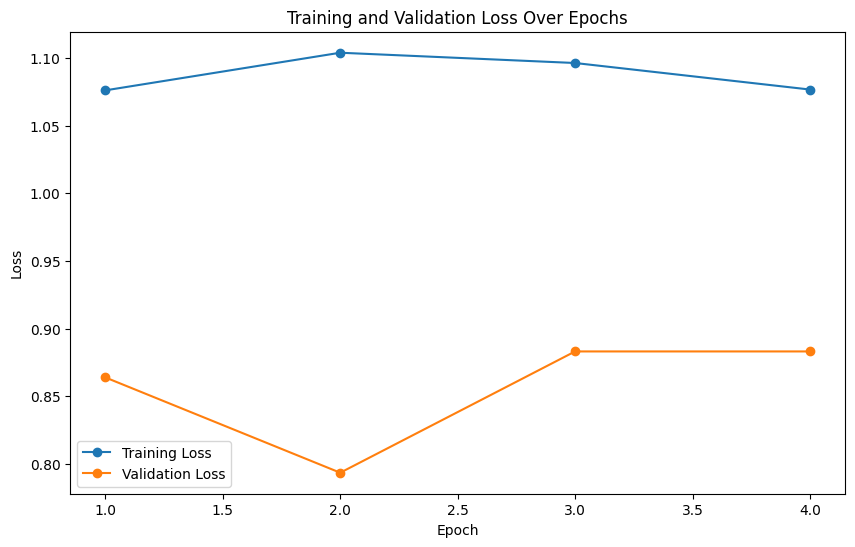

In [ ]:
import matplotlib.pyplot as plt

# Extract the training and validation loss values from the trainer's log history
training_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
validation_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]
epochs = list(range(1, len(validation_loss) + 1))

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss[:len(epochs)], label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Get model predictions on the test dataset
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Compute accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Classification report for detailed metrics
class_names = label_encoder.classes_  # Original label names
report = classification_report(y_test, predicted_labels, target_names=class_names)
print("\nClassification Report:\n", report)


Accuracy: 0.7053

Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.65      0.61      0.63      9281
     NEUTRAL       0.72      0.77      0.74     14040
    POSITIVE       0.73      0.70      0.71     11644

    accuracy                           0.71     34965
   macro avg       0.70      0.69      0.70     34965
weighted avg       0.70      0.71      0.70     34965



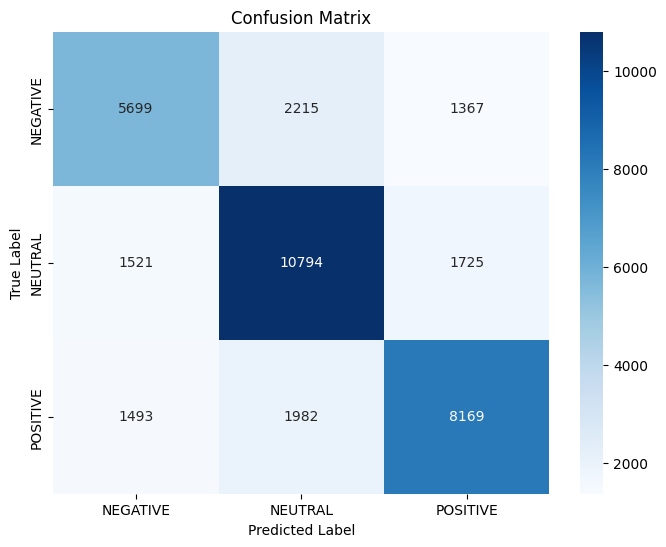

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()